# Intro

This notebook aims to use Google Colab's gratitude GPU to execute the different experiments.
It exists as a wrapping module for the project.

In order to use you'll have to upload manually:

*   dataset.py
*   model.py
*   utils.py
*   requirements.txt
*   lfwa.zip

The zipped version of the data should be structured like:

Ifwa\Files, train.txt, test.txt

Files is the folder where the folders containing the pictures should be.

The code blocks below replace the original main.py and config.py files. To try different configurations, edit the configurations block below.

The blocks below document the different executed attempts, with their results.

**This will be a good time to change your runtime to GPU**

# Setup

In [1]:
# Install any required Python packages
!pip install -r requirements.txt  # Replace with your actual requirements file if available

In [2]:
import os
import zipfile
from google.colab import files

import torch
import torchvision
import matplotlib.pyplot as plt

# Local code
from dataset import *
from utils import *
from model import *

In [3]:
# Assuming your zip file is named 'dataset.zip'
zip_file_name = '/content/lfwa.zip'

# Extract the zip file
zip_dataset_dir = "/content"
!unzip -q {zip_file_name} -d {zip_dataset_dir}

print(f"Dataset extracted to {zip_dataset_dir}")

replace /content/lfwa/Files/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset extracted to /content


# Execute Experiments

### General Configurations

In [9]:
# Paths (after unzip)
DATA_ROOT = "/content/lfwa/Files"
TRAIN_FILE = "/content/lfwa/train.txt"
TEST_FILE = "/content/lfwa/test.txt"
MODEL_DIR = "/content/trained_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Device to use ('cpu' or 'cuda')

## Main

In [10]:
def visualize_data():
    """Function to visualize a batch of data from the Siamese Network Dataset."""
    # Create the DataLoader using the configuration
        # Create the dataset
    dataset = SiameseNetworkDataset(root_dir=DATA_ROOT, file_list=TRAIN_FILE, transform=None, image_size=IMAGE_SIZE)

    # Create a DataLoader from the dataset
    dataloader = get_dataloader(dataset, batch_size=8, num_workers=NUM_WORKERS)

    # Get a batch of data
    data_iter = iter(dataloader)
    example_batch = next(data_iter)
    img1, img2, labels = example_batch

    # Stack each pair of images vertically and then concatenate the pairs horizontally
    pairs = [torch.cat((img1[i], img2[i]), dim=1) for i in range(img1.size(0))]
    concatenated = torch.cat(pairs, dim=2)

    # Generate labels for the batch
    labels = ["Twin" if label.item() == 1 else "Not Twin" for label in labels]

    # Visualize the grid with labels
    imshow(torchvision.utils.make_grid(concatenated), labels=labels)


def calculate_conv_out():
    h, w, c = calculate_cnn_output_size(CNN_BLOCKS, IMAGE_SIZE)
    print(f"Output size after Conv + Pooling: {h}X{w}X{c}={h*w*c}")


def train_model():
        # Initialize the dataset
    print("[Setup]: Initializing dataset...")
    dataset = SiameseNetworkDataset(
        root_dir=DATA_ROOT,
        file_list=TRAIN_FILE,
        image_size=IMAGE_SIZE
    )

    # Initialize the model
    print("[Setup]: Initializing model...")
    model = SiameseNetwork(CNN_BLOCKS, FC_LAYERS).to(DEVICE)

    # Start training
    print("[Training]: Starting training process...")
    train_losses, val_losses = train(
        model=model,
        dataset=dataset,
        batch_size=BATCH_SIZE,
        val_split=VAL_SPLIT,
        augment_ratio=AUGMENT_RATIO,
        epochs=(MIN_EPOCHS, MAX_EPOCHS),
        lr=LEARNING_RATE,
        l2_reg=L2_REG,
        early_stop_patience=EARLY_STOP_PATIENCE,
        save_path=SAVE_PATH,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    print("[Training]: Training complete. Model saved.")

        # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


def main_predict():
    """
    Main function to handle predictions using a trained Siamese Neural Network.
    Function will print a batch's prediction for inspection
    """
    # Initialize the test dataset
    print("[Setup]: Initializing test dataset...")
    test_dataset = SiameseNetworkDataset(
        root_dir=DATA_ROOT,
        file_list=TEST_FILE,
        image_size=IMAGE_SIZE
    )

    # Run predictions
    print("[Prediction]: Running predictions...")
    _ = predict(
        model_path=SAVE_PATH,
        cnn_blocks=CNN_BLOCKS,
        fc_layers=FC_LAYERS,
        test_dataset=test_dataset,
        batch_size=4, # For pictures visability
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Visualize a few samples from the test set
    test_loader = get_dataloader(test_dataset, batch_size=4, num_workers=NUM_WORKERS)
    data_iter = iter(test_loader)
    img1, img2, labels = next(data_iter)
    actuals = ['Same' if label.item() == 1 else 'Different' for label in labels]

    # Load the model for prediction
    model = SiameseNetwork(CNN_BLOCKS, FC_LAYERS).to(DEVICE)
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE, weights_only=True))
    model.eval()

    with torch.no_grad():
        outputs = model(img1.to(DEVICE), img2.to(DEVICE)).squeeze().cpu().tolist()  # Convert to list
        similarity_scores = [f"{actual}, Pred: {score:.2f}" for actual, score in zip(actuals, outputs)]

        # Stack each pair of images vertically
        pairs = [torch.cat((img1[i], img2[i]), dim=1) for i in range(img1.size(0))]  # dim=1 for vertical stacking
        concatenated = torch.cat(pairs, dim=2)  # Concatenate horizontally

        # Display the grid of stacked pairs with labels
        imshow(concatenated, labels=similarity_scores)


def view_mistakes(k=5):
    """
    Main function to handle predictions on the test dataset and display the k most mismatched predictions.
    Mismatched predictions are ranked by the absolute error between the predicted similarity score
    and the actual label.

    Args:
        k (int): Number of mistakes to display.
    """
    # Initialize the test dataset
    print("[Setup]: Initializing test dataset...")
    test_dataset = SiameseNetworkDataset(
        root_dir=DATA_ROOT,
        file_list=TEST_FILE,
        image_size=IMAGE_SIZE
    )

    # Load the test DataLoader
    test_loader = get_dataloader(test_dataset, batch_size=1, num_workers=NUM_WORKERS)

    # Load the trained model
    print("[Prediction]: Loading model...")
    model = SiameseNetwork(CNN_BLOCKS, FC_LAYERS).to(DEVICE)
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE, weights_only=True))
    model.eval()

    # Collect predictions and labels
    mismatches = []  # Store tuples: (abs_error, img1, img2, score, label)
    all_scores = []  # Collect all predicted scores
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(DEVICE), img2.to(DEVICE), labels.to(DEVICE)

            # Predict similarity score
            outputs, labels = model(img1, img2).squeeze(), labels.squeeze() # Remove extra dimension
            abs_error = torch.abs(outputs - labels).item()

            # Store the mismatch details
            mismatches.append((abs_error, img1.cpu(), img2.cpu(), outputs.item(), labels.item()))

            # Collect scores and labels for analysis
            all_scores.append(outputs.item())

    # Sort mismatches by absolute error in descending order
    mismatches.sort(key=lambda x: x[0], reverse=True)

    # Display the top k mismatches
    print(f"\n[Output]: Displaying top {k} mismatches:")
    for i, (abs_error, img1, img2, score, label) in enumerate(mismatches[:k]):
        print(f"\nMistake {i+1}:")
        print(f"  Predicted Score: {score:.2f}")
        print(f"  Actual Label: {label:.0f}")
        print(f"  Absolute Error: {abs_error:.2f}")

        # Visualize the mismatched images
        concatenated = torch.cat((img1, img2), 0)
        imshow(torchvision.utils.make_grid(concatenated), labels=[f"Pred: {score:.2f}", f"Label: {label:.0f}"])

    # Plot the distribution of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(all_scores, bins=20, alpha=0.7, label="Predicted Scores", color='blue')
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Predicted Scores")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 1)  # Explicitly set the x-axis range to [0, 1]
    plt.show()

    print("[Analysis]: Prediction confidence distribution plotted.")

## Ex.1

[Setup]: Initializing dataset...
[Dataloader Info]: Total number of pairs (rows in file): 2200
[Dataloader Info]: Total positives detected: 1100
[Dataloader Info]: Total negatives detected: 1100
[Setup]: Initializing model...
[Training]: Starting training process...
[Training]: Applying augmentation with ratio 3.0 to the dataset.
[Augmentation]: Augmenting dataset with ratio 3.0...
[Augmentation]: Dataset augmented. Original size: 1760, New size: 5280
[Data Distribution]: Subset Train - Positives: 2640, Negatives: 2640
[Data Distribution]: Validation - Positives: 220, Negatives: 220
[Training Status]: Epoch 1, Train Loss: 0.7014 (acc 0.556), Val Loss: 0.7098 (acc 0.511), Time: 0.6 min, LR: 1.00e-03
[Training Status]: Epoch 2, Train Loss: 0.6856 (acc 0.569), Val Loss: 0.6789 (acc 0.561), Time: 1.0 min, LR: 1.00e-03
[Training Status]: Epoch 3, Train Loss: 0.6818 (acc 0.569), Val Loss: 0.6694 (acc 0.650), Time: 1.5 min, LR: 1.00e-03
[Training Status]: Epoch 4, Train Loss: 0.6704 (acc 0.59

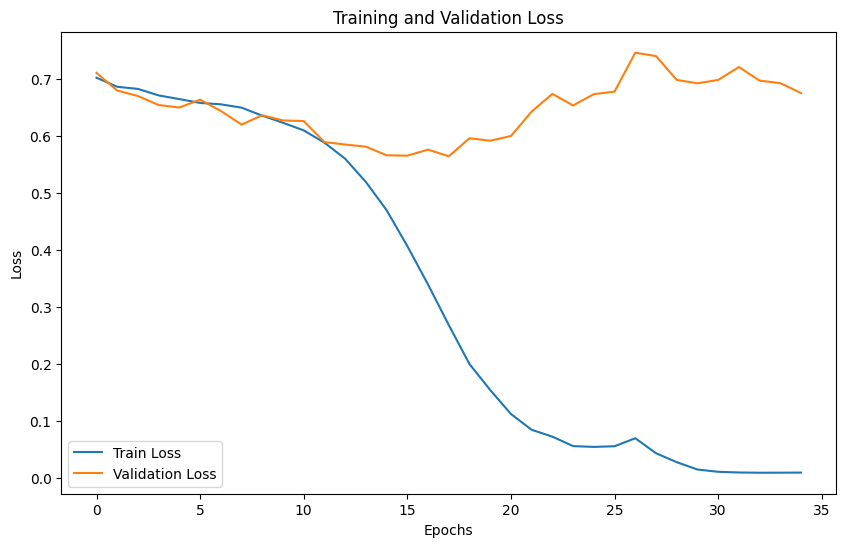

[Setup]: Initializing test dataset...
[Dataloader Info]: Total number of pairs (rows in file): 1000
[Dataloader Info]: Total positives detected: 500
[Dataloader Info]: Total negatives detected: 500
[Prediction]: Running predictions...
[Prediction]: Loading model from /content/trained_models/model1_best_checkpoint.pth...
[Prediction]: Starting predictions...
[Prediction]: Accuracy: 0.6900


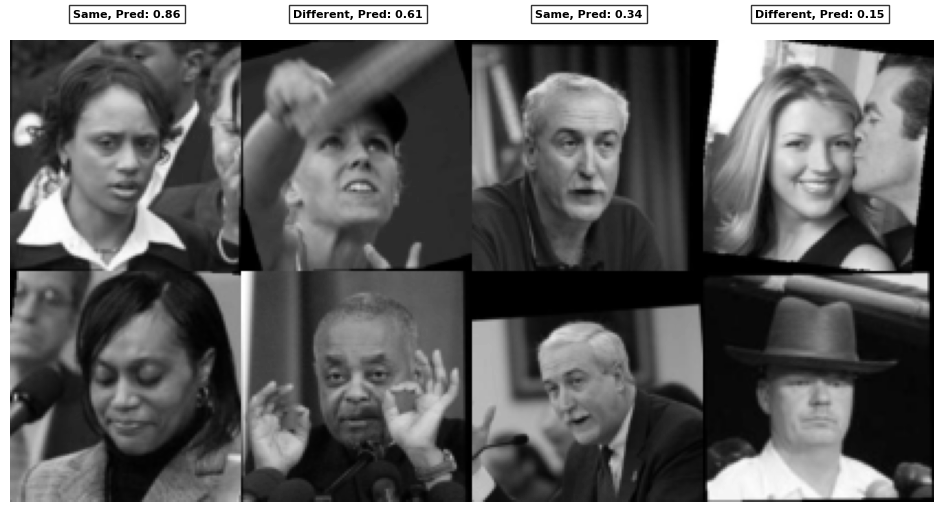

[Setup]: Initializing test dataset...
[Dataloader Info]: Total number of pairs (rows in file): 1000
[Dataloader Info]: Total positives detected: 500
[Dataloader Info]: Total negatives detected: 500
[Prediction]: Loading model...

[Output]: Displaying top 5 mismatches:

Mistake 1:
  Predicted Score: 0.98
  Actual Label: 0
  Absolute Error: 0.98


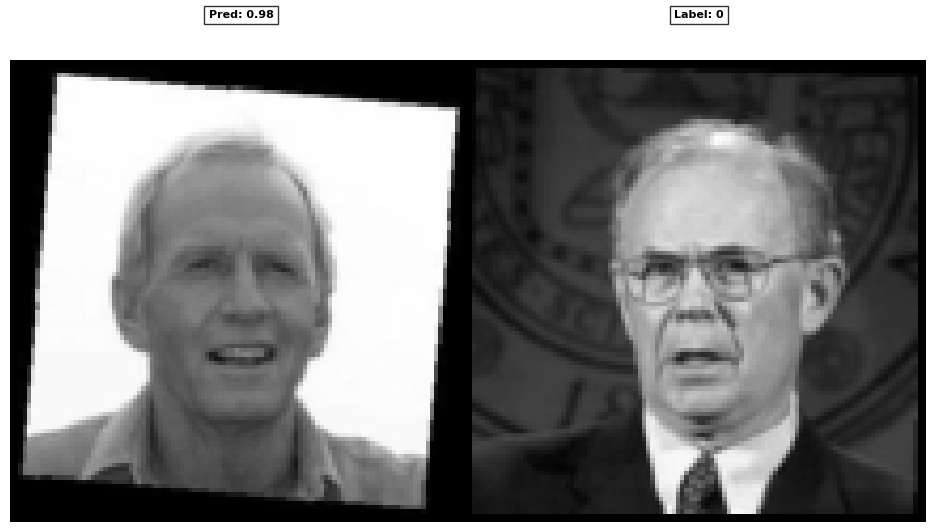


Mistake 2:
  Predicted Score: 0.97
  Actual Label: 0
  Absolute Error: 0.97


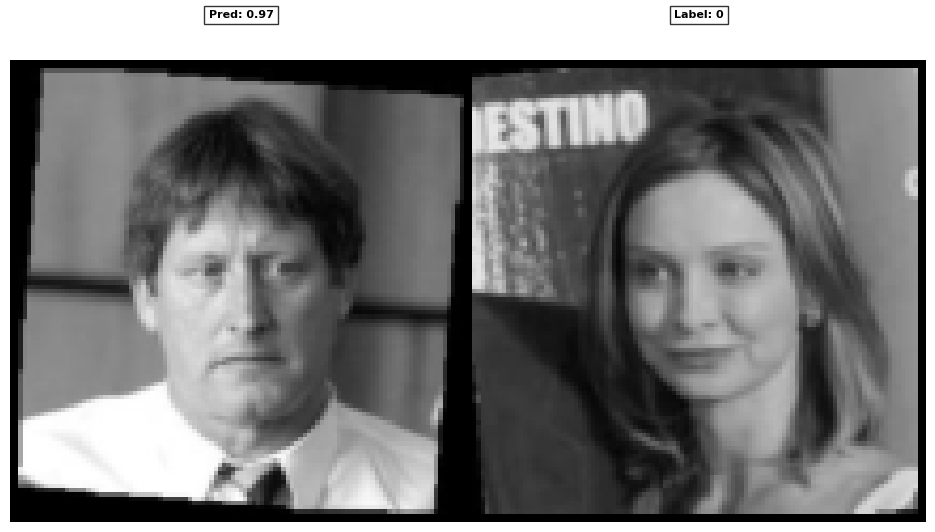


Mistake 3:
  Predicted Score: 0.03
  Actual Label: 1
  Absolute Error: 0.97


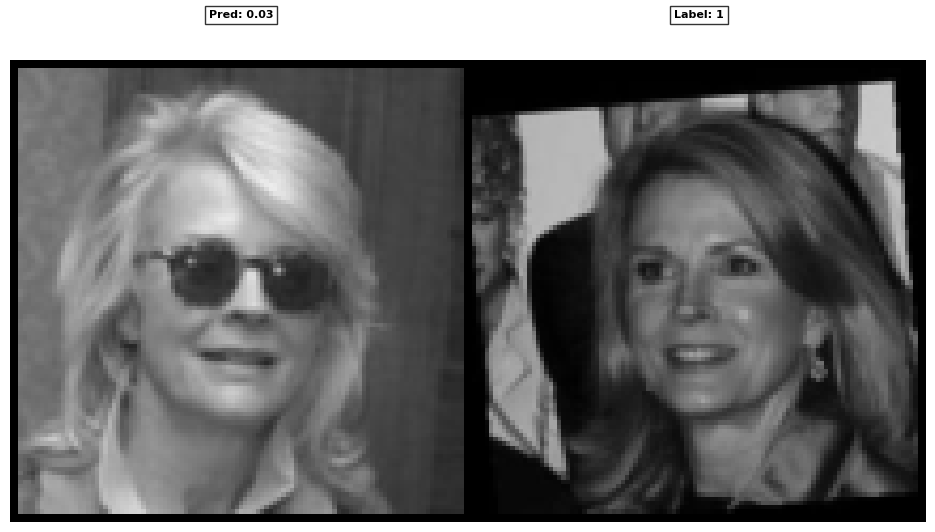


Mistake 4:
  Predicted Score: 0.96
  Actual Label: 0
  Absolute Error: 0.96


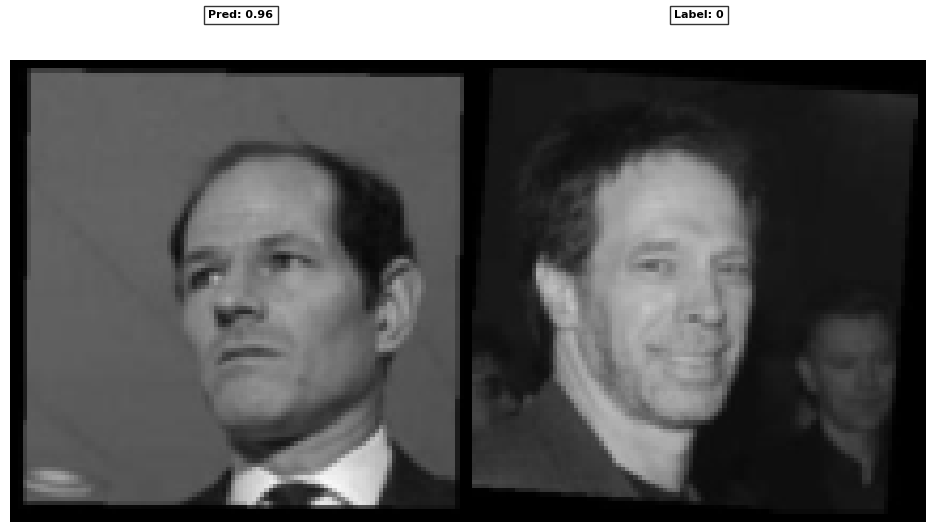


Mistake 5:
  Predicted Score: 0.04
  Actual Label: 1
  Absolute Error: 0.96


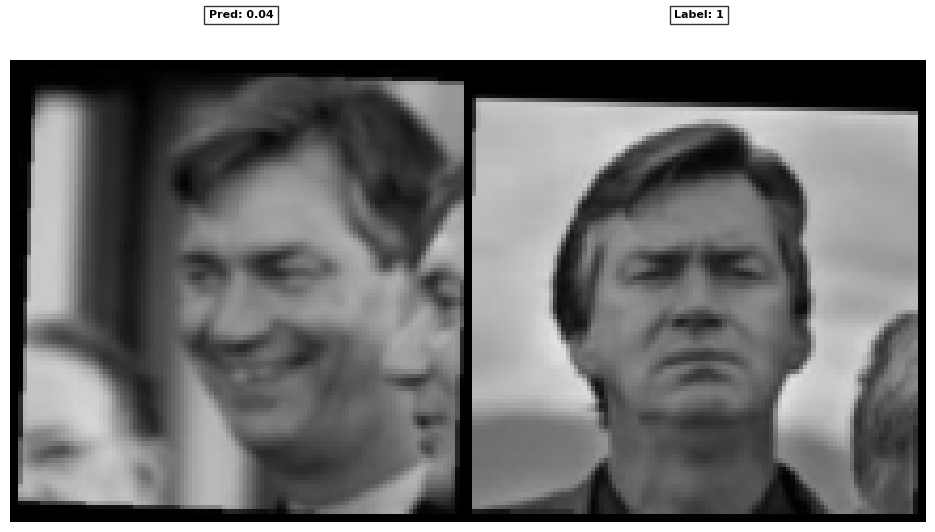

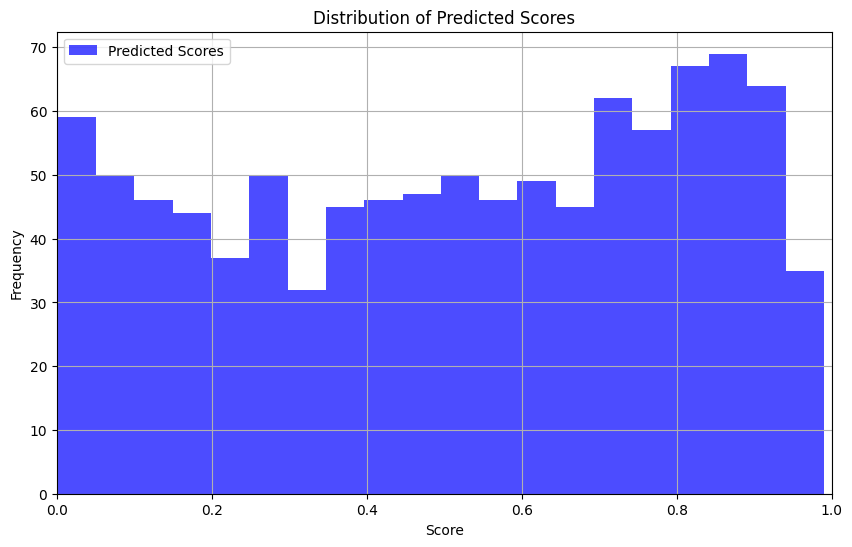

[Analysis]: Prediction confidence distribution plotted.


In [11]:
# Save Path
MODEL_NAME = "model1_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (105, 105)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.0
BATCHNORM = False

# CNN Block Configurations
CNN_BLOCKS = [
    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 105x105 -> 48x48
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 48x48 -> 21x21
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 21x21 -> 9x9
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 9x9 -> 6x6
]

FC_LAYERS = [
    {"in_features": 256 * 6 * 6, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.2

In [ ]:
# Save Path
MODEL_NAME = "model2_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (105, 105)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.0
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 105x105 -> 48x48
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 48x48 -> 21x21
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 21x21 -> 9x9
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 9x9 -> 6x6
]

FC_LAYERS = [
    {"in_features": 256 * 6 * 6, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                  # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

[Setup]: Initializing dataset...
[Dataloader Info]: Total number of pairs (rows in file): 2200
[Dataloader Info]: Total positives detected: 1100
[Dataloader Info]: Total negatives detected: 1100
[Setup]: Initializing model...
[Training]: Starting training process...
[Training]: Applying augmentation with ratio 3.0 to the dataset.
[Augmentation]: Augmenting dataset with ratio 3.0...
[Augmentation]: Dataset augmented. Original size: 1760, New size: 5280
[Data Distribution]: Subset Train - Positives: 2640, Negatives: 2640
[Data Distribution]: Validation - Positives: 220, Negatives: 220
[Training Status]: Epoch 1, Train Loss: 0.7203 (acc 0.517), Val Loss: 0.6971 (acc 0.527), Time: 0.6 min, LR: 1.00e-03
[Training Status]: Epoch 2, Train Loss: 0.6856 (acc 0.565), Val Loss: 0.6626 (acc 0.593), Time: 1.1 min, LR: 1.00e-03
[Training Status]: Epoch 3, Train Loss: 0.6802 (acc 0.563), Val Loss: 0.6573 (acc 0.614), Time: 1.5 min, LR: 1.00e-03
[Training Status]: Epoch 4, Train Loss: 0.6841 (acc 0.55

## Ex.3

In [ ]:
# Save Path
MODEL_NAME = "model3_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (105, 105)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = False

# CNN Block Configurations
CNN_BLOCKS = [
    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 105x105 -> 48x48
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 48x48 -> 21x21
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 21x21 -> 9x9
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 9x9 -> 6x6
]

FC_LAYERS = [
    {"in_features": 256 * 6 * 6, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-5                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.4

In [ ]:
# Save Path
MODEL_NAME = "model4_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (105, 105)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 105x105 -> 48x48
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 48x48 -> 21x21
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 21x21 -> 9x9
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 9x9 -> 6x6
]

FC_LAYERS = [
    {"in_features": 256 * 6 * 6, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.5

In [ ]:
# Save Path
MODEL_NAME = "model5_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (250, 250)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    # New layers to handle the larger input size
    {"out_channels": 32, "kernel_size": 15, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 250x250 -> 236x236
    {"out_channels": 64, "kernel_size": 15, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 236x236 -> 222x222
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 222x222 -> 105x105

    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 105x105 -> 48x48
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 48x48 -> 21x21
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},   # 21x21 -> 9x9
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 9x9 -> 6x6
]

FC_LAYERS = [
    {"in_features": 256 * 6 * 6, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.6

In [ ]:
# Save Path
MODEL_NAME = "model6_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (250, 250)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = False

# CNN Block Configurations
CNN_BLOCKS = [
    # New layers to handle the larger input size
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},

    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
]

FC_LAYERS = [
    {"in_features": 256 * 7 * 7, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.7

In [ ]:
# Save Path
MODEL_NAME = "model7_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (250, 250)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    # New layers to handle the larger input size
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},

    # Original architecture
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
    {"out_channels": 128, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},
]

FC_LAYERS = [
    {"in_features": 256 * 7 * 7, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.8

In [ ]:
# Save Path
MODEL_NAME = "model8_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (250, 250)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    {"out_channels": 64, "kernel_size": 10, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 250x250 -> 120x120
    {"out_channels": 128, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 120x120 -> 58x58
    {"out_channels": 256, "kernel_size": 5, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 58x58 -> 28x28
    {"out_channels": 256, "kernel_size": 4, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 28x28 -> 13x13
    {"out_channels": 512, "kernel_size": 3, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 13x13 -> 11x11
]

FC_LAYERS = [
    {"in_features": 512, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.9

In [ ]:
# Save Path
MODEL_NAME = "model9_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (250, 250)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    {"out_channels": 32, "kernel_size": 10, "stride": 2, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 250x250 -> 121x121
    {"out_channels": 64, "kernel_size": 7, "stride": 2, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 121x121 -> 58x58
    {"out_channels": 128, "kernel_size": 5, "stride": 2, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 58x58 -> 27x27
    {"out_channels": 256, "kernel_size": 3, "stride": 2, "padding": 1, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 27x27 -> 14x14
]

FC_LAYERS = [
    {"in_features": 256 * 14 * 14, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()

## Ex.10

In [ ]:
# Save Path
MODEL_NAME = "model10_best_checkpoint.pth"        # Path to save the best model
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# DataLoader Parameters
BATCH_SIZE = 16      # Batch size for training and validation
NUM_WORKERS = 2     # Number of worker threads for DataLoader

# Image Transformation Parameters
IMAGE_SIZE = (250, 250)  # Matches the input size of the dataset

# Model Parameters:
DROPOUT = 0.3
BATCHNORM = True

# CNN Block Configurations
CNN_BLOCKS = [
    {"out_channels": 32, "kernel_size": 7, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 250x250 -> 122x122
    {"out_channels": 64, "kernel_size": 5, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 122x122 -> 60x60
    {"out_channels": 128, "kernel_size": 3, "stride": 1, "padding": 0, "use_pooling": True,  "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 60x60 -> 29x29
    {"out_channels": 256, "kernel_size": 3, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 29x29 -> 27x27
    {"out_channels": 512, "kernel_size": 3, "stride": 1, "padding": 0, "use_pooling": False, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT},  # 27x27 -> 25x25
]

FC_LAYERS = [
    {"in_features": 512 * 24 * 24, "out_features": 4096, "use_batchnorm": BATCHNORM, "dropout_prob": DROPOUT}, # Fully Connected Layer, # 6x6 -> 1X4096
    {"in_features": 4096, "out_features": 1, "use_batchnorm": False, "dropout_prob": 0.0},  # Final similarity score layer (1X4096 -> 1X1)
]

# Training Parameters
VAL_SPLIT = 0.2                   # Fraction of data for validation (out of train)
AUGMENT_RATIO = 3.0               # Augment the data X3
MIN_EPOCHS = 20                   # Min number of training epochs
MAX_EPOCHS = 200                      # Max number of training epochs
LEARNING_RATE = 1e-3              # Learning rate for the optimizer
L2_REG = 1e-3                     # L2 regularization strength
EARLY_STOP_PATIENCE = 15          # Number of epochs for early stopping


# Activate Main
train_model()
main_predict()
view_mistakes()